# Fake News Classifier

### Data Reading and Interpretation

__Import Statements__

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from os import path
import re
import string
import altair as alt
import matplotlib.pyplot as plt

from collections import Counter

import nltk

# nltk.download('words')
# nltk.download("cmudict")
# nltk.download("vader_lexicon")
# nltk.download("punkt")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import cmudict, stopwords

from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer
)
from sklearn.ensemble import RandomForestClassifier
#from similarity.jarowinkler import JaroWinkler
#from similarity.cosine import Cosine
#from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer
)

from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from wordcloud import WordCloud

alt.data_transformers.enable('data_server')
# alt.renderers.enable('mimetype')

DataTransformerRegistry.enable('data_server')

In [2]:
if os.path.exists( "../data/processed/train.csv"):
    train_df = pd.read_csv("../data/processed/train.csv")
    print("Read processed data")
else:
    train_df = pd.read_csv("../data/raw/train.csv")
    print("Read raw data")

Read raw data


### Data Cleaning 

- Deal NaNs/Nulls and empty texts

In [3]:
def remove_punctuation(word):
    punctuations = string.punctuation
    punctuations += "“”–\n"

    for element in word:
        if element in punctuations:
            word = word.replace(element, "")
    return word


def clean_data(text):
    text = str(text).lower()
    text = str(text).strip()
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = remove_punctuation(text)
    return text

In [4]:
train_df["title"] = train_df["title"].apply(clean_data)

In [5]:
train_df["text"] = train_df["text"].apply(clean_data)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20800 non-null  object
 2   author  18843 non-null  object
 3   text    20800 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [7]:
train_df.isnull().sum()

id           0
title        0
author    1957
text         0
label        0
dtype: int64

In [8]:
train_df.describe(include="all")

,id,title,author,text,label
count,20800.000000,20800,18843,20800,20800.000000
unique,NaN,19708,4201,20380,NaN
top,NaN,nan,Pam Key,,NaN
freq,NaN,558,243,77,NaN
mean,10399.500000,NaN,NaN,NaN,0.500625
std,6004.587135,NaN,NaN,NaN,0.500012
min,0.000000,NaN,NaN,NaN,0.000000
25%,5199.750000,NaN,NaN,NaN,0.000000
50%,10399.500000,NaN,NaN,NaN,1.000000
75%,15599.250000,NaN,NaN,NaN,1.000000


### EDA

<AxesSubplot:>

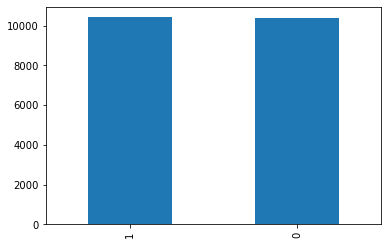

In [9]:
train_df["label"].value_counts().plot.bar()

__There is no class imbalance__

In [10]:
fake = " ".join(train_df[train_df["label"] == 1]["text"])
real = " ".join(train_df[train_df["label"] == 0]["text"])

In [11]:
stop_words = stopwords.words("English")

In [12]:
# wordcloud_fake = WordCloud(
#     stopwords=stop_words,
#     max_font_size=40,
#     width=400,
#     height=200
# ).generate(fake).to_image()

# plt.imshow(wordcloud_fake)
# plt.axis("off")
# plt.show()

In [13]:
# wordcloud_real = WordCloud(
#     stopwords=stop_words,
#     max_font_size=40,
#     width=400,
#     height=200
# ).generate(real).to_image()

# plt.imshow(wordcloud_real)
# plt.axis("off")
# plt.show()

In [14]:
real_counter = Counter(word for word in real.split(" ") if word not in stop_words)

In [15]:
fake_counter = Counter(word for word in fake.split(" ") if word not in stop_words)

In [16]:
# fake[:5000]

In [17]:
# df_real = pd.DataFrame.from_dict(
#     real_counter,
#     orient="index",
#     columns=["count"]
# ).reset_index().sort_values("count", ascending=False).head(20)

# df_real

In [18]:
# df_fake = pd.DataFrame.from_dict(
#     fake_counter,
#     orient="index",
#     columns=["count"]
# ).reset_index().sort_values("count", ascending=False).head(20)

In [19]:
# alt.Chart(df_real, title="Frequency of top 10 words in Real News").mark_bar().encode(
#     x="index",
#     y="counts"
# )

In [20]:
# alt.Chart(df_fake, title="Frequency of top 10 words in Fake News").mark_bar().encode(
#     alt.X("index", sort="-y"),
#     alt.Y("count")
# )

# plot = sns.countplot(x="index", data = df_fake)
# plt.show()

### Preprocessing and Feature Engineering

#### Author Feature

In [21]:
# Create a feature "author_is_null"

def author_is_null(x):
    if x["author"] != x["author"]:
        return 0
    return 1

train_df["author_is_null"] = train_df.apply(lambda x: author_is_null(x), axis=1)

In [22]:
# Change Author = Null to Author = "Unknown"

unknown_authors_ids = train_df.query("author.isnull()")["id"]
train_df['updated_author_column_name'] = np.where(~train_df['id'].isin(unknown_authors_ids), train_df['author'], 'Unknown')

In [23]:
# Others category if value_counts of an author is less than 5

less_frequent = train_df['author'].value_counts()[train_df['author'].value_counts() <= 5].index.tolist()
train_df['author'] = np.where(train_df['author'].isin(less_frequent), 'Other', train_df['author'])

In [24]:
# Create if "is_multiple_authors"

def is_multiple_authors(data):

    data["is_multiple_authors"] = [
        1 if " and " in str(author) else 0 for author in data["author"]
    ]

    return data


train_df = is_multiple_authors(train_df)

train_df.query("is_multiple_authors == 1")["label"].value_counts()

0    198
1      7
Name: label, dtype: int64

In [25]:
# Check if author name contains a domain suffix

def author_contains_domain(data):

    data["author_contains_domain"] = [
        1 if re.search(r"\.[a-zA-Z]{3}", str(author)) else 0 for author in train_df["author"]
    ]

    return data


train_df = author_contains_domain(train_df)

train_df.query("author_contains_domain == 1")["label"].value_counts()

1    480
Name: label, dtype: int64

#### Title Feature

In [26]:
# Check if title is null

def is_title_null(data):

    data["is_title_null"] = [
        0 if title == title
        else 1 for title in train_df["title"]
    ]

    return data


train_df = is_title_null(train_df)

train_df.query("is_title_null == 1")["label"].value_counts()

Series([], Name: label, dtype: int64)

In [27]:
# Check if title ends with a famous journal name

def title_contains_famous_journal(data):

    data["title_contains_famous_journal"] = [
        1 if
        str(title).endswith("The New York Times") or
        str(title).endswith("Breitbart")
        else 0 for title in train_df["title"]
    ]

    return data


train_df = title_contains_famous_journal(train_df)

train_df.query("title_contains_famous_journal == 1")["label"].value_counts()

Series([], Name: label, dtype: int64)

In [28]:
def no_of_words(data):

    data["no_of_words"] = [
        len(str(title).split(" ")) for title in train_df["title"]
    ]

    return data


train_df = no_of_words(train_df)

In [29]:
# alt.Chart(train_df).mark_bar().encode(
#     alt.X("no_of_words", bin=alt.Bin(maxbins=50)),
#     alt.Y("count()"),
#     color="label"
# )

In [30]:
def no_of_chars(data):

    data["no_of_chars"] = [
        len(str(title)) for title in train_df["title"]
    ]

    return data


train_df = no_of_chars(train_df)

In [31]:
# alt.Chart(train_df).mark_bar().encode(
#     alt.X("no_of_chars", bin=alt.Bin(maxbins=100)),
#     alt.Y("count()"),
#     color="label"
# )

In [32]:
def get_text_length(text):
    """
    Returns the number of words in a text without punctuations. 
    Counts clitics as separate words.

    Parameters
    ----------
    text : str
        A text from which we find the number of words

    Returns
    -------
    An int which represents the number of words in the text
    """
    non_punc = []
    for word in word_tokenize(str(text)):
        if word not in string.punctuation:
            non_punc.append(word)
    return len(non_punc)

In [33]:
train_df = train_df.assign(title_len=train_df["title"].apply(get_text_length))

In [54]:
def get_pos_count(text):
    """
    Counts the number of nouns, verbs and adjectives in a text.

    Parameters
    ----------
    text : str
        A text for which we find the number of nouns, verbs
        and adjectives

    Returns
    -------
    A tuple of (noun_count: int, verb_count: int, adj_count: int)
    which represents the number of nouns, verbs adjectives in the text
    respectively
    """
    noun_count = 0
    verb_count = 0
    adj_count = 0

    if len(str(text)) == 0:
        return 0, 0, 0

    for word, pos in pos_tag(word_tokenize(str(text))):
        if(pos[0] == 'N'):
            noun_count += 1
        if(pos[0] == 'V'):
            verb_count += 1
        if(pos == 'JJ'):
            adj_count += 1
    return noun_count, verb_count, adj_count

In [57]:
pos_title = train_df["title"].apply(get_pos_count)

In [65]:
train_df["count_noun_title"], train_df["count_verb_title"], train_df["count_adj_title"] = (
    pos_title.str[0],
    pos_title.str[1],
    pos_title.str[2]
)

#### Text Feature

In [37]:
# # Check if text is empty

def is_text_empty(data):

    data["is_text_empty"] = [
        1 if text == " " or
        not text == text
        else 0 for text in train_df["text"]
    ]

    return data
train_df.query("text == ' '")["label"].value_counts()

Series([], Name: label, dtype: int64)

In [38]:
train_df = is_text_empty(train_df)

In [39]:
train_df["text_len"] = train_df["text"].apply(get_text_length)

In [67]:
pos_text = train_df["text"].apply(get_pos_count)

train_df["count_noun_text"], train_df["count_verb_text"], train_df["count_adj_text"] = (
    pos_text.str[0],
    pos_text.str[1],
    pos_text.str[2]
)

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             20800 non-null  int64  
 1   title                          20800 non-null  object 
 2   author                         18843 non-null  object 
 3   text                           20800 non-null  object 
 4   label                          20800 non-null  int64  
 5   author_is_null                 20800 non-null  int64  
 6   updated_author_column_name     20800 non-null  object 
 7   is_multiple_authors            20800 non-null  int64  
 8   author_contains_domain         20800 non-null  int64  
 9   is_title_null                  20800 non-null  int64  
 10  title_contains_famous_journal  20800 non-null  int64  
 11  no_of_words                    20800 non-null  int64  
 12  no_of_chars                    20800 non-null 

#### Cosine Similarity between Title and Text

In [70]:
def get_jaccard_sim(str1, str2):
    str1_set = set(str1.split())
    str2_set = set(str2.split())
    intersection = str1_set.intersection(str2_set)
    return float(len(intersection)) / (len(str1_set) + len(str2_set) - len(intersection))


def get_title_text_similarity(data):
    data["title_text_sim"] = data.apply(lambda x: get_jaccard_sim(str(x["title"]), str(x["text"])), axis=1)
    return data

In [71]:
train_df = get_title_text_similarity(train_df)

In [72]:
# alt.Chart(df).mark_bar().encode(
#     alt.X("title_text_sim", bin=alt.Bin(maxbins=50)),
#     alt.Y("count()"),
#     color="label"
# ).properties(
#     height=400,
#     width=600
# )

In [73]:
train_df["text"] = train_df["text"].values.astype("U")

In [74]:
train_df.columns

Index(['id', 'title', 'author', 'text', 'label', 'author_is_null',
       'updated_author_column_name', 'is_multiple_authors',
       'author_contains_domain', 'is_title_null',
       'title_contains_famous_journal', 'no_of_words', 'no_of_chars',
       'title_len', 'count_pos_title', 'count_noun_title', 'count_verb_title',
       'count_adj_title', 'is_text_empty', 'text_len', 'text_pos_count',
       'count_noun_text', 'count_verb_text', 'count_adj_text',
       'title_text_sim'],
      dtype='object')

### Preprocessor

In [75]:
train_df_small, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

In [76]:
X_train, y_train = train_df_small.drop(columns=["label"]), train_df_small["label"]

In [77]:
text_features1 = [
    "title"
]
text_features2 = [
    "text"
]
binary_features = [
    "author_is_null",
    "is_multiple_authors",
    "author_contains_domain",
    "is_title_null", 
    "title_contains_famous_journal",
    "is_text_empty"
]
numeric_features = [
    "no_of_words",
    "no_of_chars",
    "title_len",
    "count_noun_title",
    "count_verb_title",
    "count_adj_title",
    "text_len",
    "count_noun_text",
    "count_verb_text",
    "count_adj_text",
    "title_text_sim"
]
pass_through = []

drop = [
    "id",
    "author",
    "updated_author_column_name",
    "count_pos_title",
    "text_pos_count"
]

In [78]:
assert (
    len(text_features1) +
    len(text_features2) +
    len(binary_features) +
    len(numeric_features) +
    len(pass_through) +
    len(drop)
) == len(X_train.columns)

In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16640 entries, 10250 to 19966
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             16640 non-null  int64  
 1   title                          16640 non-null  object 
 2   author                         15077 non-null  object 
 3   text                           16640 non-null  object 
 4   author_is_null                 16640 non-null  int64  
 5   updated_author_column_name     16640 non-null  object 
 6   is_multiple_authors            16640 non-null  int64  
 7   author_contains_domain         16640 non-null  int64  
 8   is_title_null                  16640 non-null  int64  
 9   title_contains_famous_journal  16640 non-null  int64  
 10  no_of_words                    16640 non-null  int64  
 11  no_of_chars                    16640 non-null  int64  
 12  title_len                      16640 non-n

In [85]:
function_transformer = FunctionTransformer(
    np.reshape, kw_args={"newshape": -1}
)

enc1 = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    function_transformer,
    CountVectorizer(stop_words="english", ngram_range=(1, 2), max_features=1000)
)

enc2 = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    function_transformer,
    CountVectorizer(stop_words="english", ngram_range=(1, 2), max_features=1000)
)

standard_scalar = make_pipeline(StandardScaler())

onehotencoder = make_pipeline(OneHotEncoder(handle_unknown="ignore", sparse=False, drop="if_binary"))

In [86]:
preprocessor = make_column_transformer(
    (enc1, text_features1),
    (enc2, text_features2),
    (standard_scalar, numeric_features),
    (onehotencoder, binary_features),
    ("drop", drop)
)

In [88]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function reshape at 0x10f485ea0>,
                                                                      kw_args={'newshape': -1})),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'))]),
                                 ['title']),
                                ('pipeline-2',
          

In [89]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function reshape at 0x10f485ea0>,
                                                                      kw_args={'newshape': -1})),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'))]),
                                 ['title']),
                                ('pipeline-2',
          

In [90]:
new_cols = (
    preprocessor.named_transformers_["pipeline-1"].named_steps["countvectorizer"].get_feature_names_out().tolist() + 
    preprocessor.named_transformers_["pipeline-2"].named_steps["countvectorizer"].get_feature_names_out().tolist() +
    numeric_features +
    binary_features
)

In [91]:
X_transformed = preprocessor.transform(X_train)

In [92]:
pd.DataFrame(X_transformed.toarray(), columns=new_cols).to_csv("apple.csv")

In [96]:
pd.DataFrame(X_transfomed.toarray(), columns=new_cols)

,10,100,11,12,15,20,2016,2017,30,50,...,count_noun_text,count_verb_text,count_adj_text,title_text_sim,author_is_null,is_multiple_authors,author_contains_domain,is_title_null,title_contains_famous_journal,is_text_empty
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.676403,-0.698509,-0.716584,1.511901,1.0,0.0,0.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.619180,-0.585214,-0.669852,0.532795,1.0,0.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.349979,0.822030,1.806930,-0.540106,1.0,0.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.726895,-0.793916,-0.786681,0.749539,1.0,0.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.460974,-0.543474,-0.447876,0.429633,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.316232,-0.346698,-0.377779,0.107757,1.0,0.0,0.0,1.0,1.0,1.0
16636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.050312,-0.096256,0.019441,-0.065191,0.0,0.0,0.0,1.0,1.0,1.0
16637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.828236,1.424283,1.117637,-0.530481,1.0,0.0,0.0,1.0,1.0,1.0
16638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.168484,-0.000850,0.194685,-0.347420,1.0,0.0,0.0,1.0,1.0,1.0


### Modelling

__Split into Training and Validation data__

#### Base models 

In [ ]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=100000))
#pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier())
pipe_nb = make_pipeline(
    preprocessor,
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
    GaussianNB())
#pipe_svc = make_pipeline(preprocessor, SVC())
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier())
pipe_catboost = make_pipeline(preprocessor, CatBoostClassifier(verbose=False))

In [ ]:
models = {
    "Logistic Regression": pipe_lr,
    #"Decision Tree": pipe_dt,
    "NB": pipe_nb,
    #"SVC": pipe_svc,
    "Random Forest": pipe_rf,
    "Cat boost": pipe_catboost
}

In [ ]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [ ]:
results = {}

for name, value in models.items():
    print(f"Start {name}!")
    results[name] = mean_std_cross_val_scores(
        value, X_train, y_train, cv=10, return_train_score=True
    )
    print(f"Done {name}!")
    display(pd.DataFrame(results))



In [ ]:
pipe_lr.fit(X_train, y_train)

In [ ]:
pipe_lr.named_steps["logisticregression"].coef_

In [ ]:
data = {
    "Importance": pipe_lr.named_steps["logisticregression"].coef_.flatten(),
    "abs_Importance": np.abs(pipe_lr.named_steps["logisticregression"].coef_.flatten())
}

pd.DataFrame(data=data, index=new_cols).sort_values(
    by="abs_Importance", ascending=False
)[:30]

#### HyperParam Tune best performing models

### Prediction and Results